In [ ]:
https://github.com/DirkEngfer/PandasTests
Monthly precipitation [mm] summed up in (Schleswig-Holstein/Germany). programmer: Dirk Engfer, Germany
Provided Input data file: wetter_historical_Schleswig.csv

------------------------------
Original source of Input Data:
------------------------------

Datenquelle:
https://www.dwd.de/DE/leistungen/klimadatendeutschland/klarchivtagmonat.html?nn=510076
    
Deutscher Wetterdienst
Zentraler Vertrieb Klima und Umwelt
Frankfurter Straße 135
Postfach 100465
63004 Offenbach

Copyright notice by data provider:
https://www.dwd.de/DE/service/copyright/copyright_node.html


In [1]:
import os, numpy as np
import pandas as pd
from matplotlib import pyplot as plt
homedir = os.getenv('HOME')

datapath = os.path.join(homedir, 'Dokumente','python-apps','tensorflow', 'eu_air_pollution_data')
datafile = 'wetter_historical_Schleswig.csv'

indatapath = os.path.join(datapath,datafile)

      0
0   5.0
1   6.0
2   NaN
3   NaN
4   8.0
5   3.0
6   5.0
7   7.0
8   3.0
9   6.0
10  NaN
11  3.0
12  8.0
13  5.0


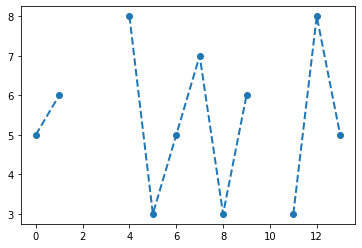

In [2]:
a = pd.DataFrame([5,6,-1,-1, 8,3,5,7,3,6,-1,3,8,5])

# Prepare a boolean mask
mask = a > 0

# New data frame with missing values filled with the last element of   
# the previous segment. Choose 'bfill' to use the first element of 
# the next segment.
a_masked = a[mask]#.fillna(method = 'ffill')
print(a_masked)
fig, ax = plt.subplots()
ax.plot(a_masked, ls = '--', lw = 2)
ax.scatter(range(len(a)),a_masked)
#ax.plot(a[mask], color='r', lw=1.5, marker = 'o')

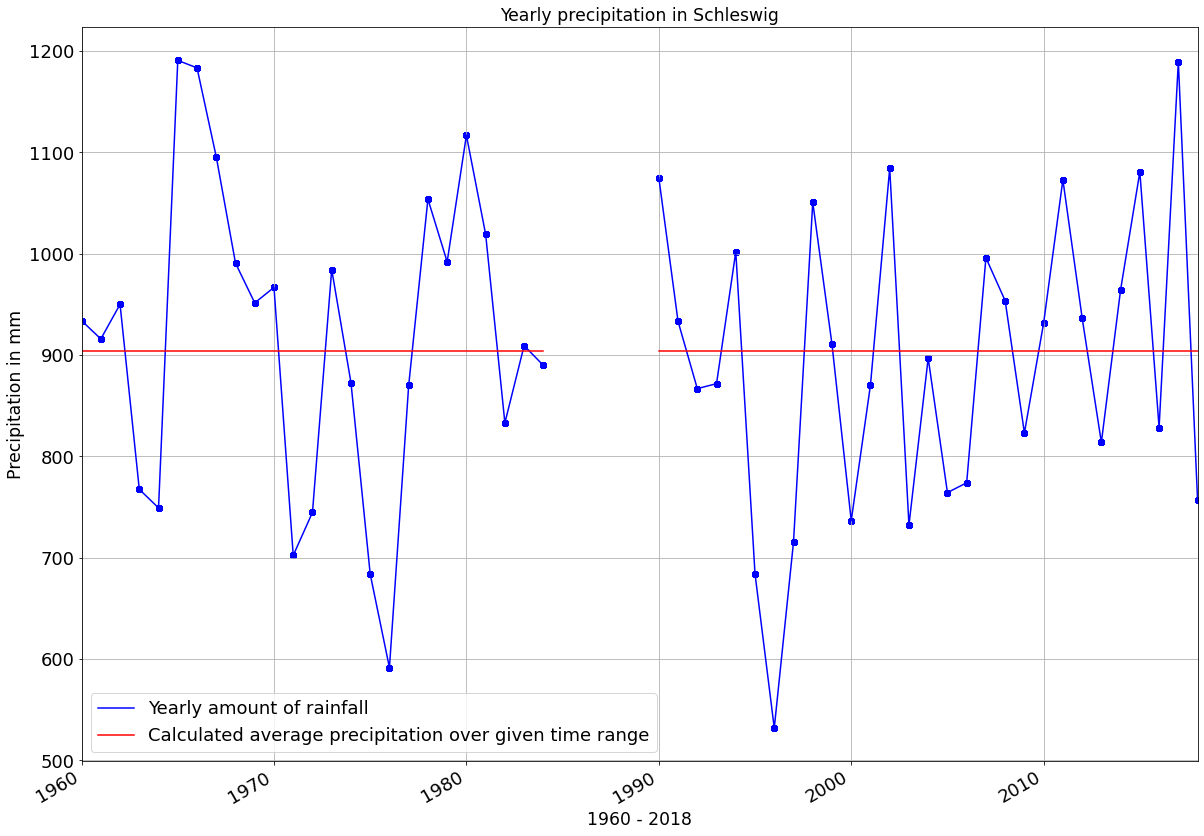

In [11]:
df = pd.read_csv(indatapath, header=0, sep=';',usecols=[1,14])
df['start_dt'] = pd.to_datetime(df.MESS_DATUM_BEGINN, format='%Y%m%d')
df['year'] = df['start_dt'].dt.year
df.sort_values(by=['year'], ascending=[True], inplace=True, axis=0)
df.rename(columns={"MO_RR": "rain"}, inplace=True) # rain includes all kind of precipitation
df = df.loc[(df.start_dt >= pd.to_datetime('19600101', format='%Y%m%d'))] # from year 1960
df = df.loc[(df.rain >= 0)] # discard negative values

# check all months were reported:
#print(df.groupby(['year'], sort=False, as_index=False).year.count())
# Exclude incomplete years i.e. the ones with less than 12 obs:
g = df.groupby('year', sort=False)
valid = pd.DataFrame(g['rain'].count())
valid.rename(columns={'rain':'months_with_measures'}, inplace=True)
valid = valid.loc[(valid['months_with_measures'] == 12)]
valid['year_'] = valid.index
df = df.merge(valid, left_on='year', right_on='year_', how='inner', sort=False)
# Build skeleton to complete all years in time range:
skeleton = pd.DataFrame({'year':np.arange(1960, 2018+1)})
yearly = df.groupby('year')['rain'].sum() # returns Series object
df['yearly_mean'] = yearly.mean() # mean over all years
df = df.merge(yearly, left_on='year', right_on='year', how='inner')
df.rename(columns={'rain_y':'rain_sum'}, inplace=True)
# Get in full range of years from skeleton:
# skeleton for years enables line plot with disconnected segments
df = df.merge(skeleton, how='right')
#Build up groups of time periods with measures vs time points with gaps:
# below code is another option to display gaps in the line plot
'''first_isna = df.loc[df.rain_sum.isna()].index[0]
df.loc[df.index < first_isna, ['period1']] = df.rain_sum
follow = df.loc[df.index > first_isna] # all obs following the first NaN
next_period_start = follow.loc[follow.rain_sum.notna()].index[0]
df.loc[df.index >= next_period_start, ['period2']] = df.rain_sum
'''
fig, ax = plt.subplots(figsize=[20,15])
#ax.plot(df['year'], df['period1'], label='Yearly amount of rainfall', color='b')
#ax.plot(df['year'], df['period2'], label=None, color='b')
ax.plot(df['year'], df['rain_sum'], label='Yearly amount of rainfall', color='b')
ax.scatter(df['year'], df.rain_sum, color='b')
ax.plot(df['year'], df['yearly_mean'], color='r', label='Calculated average precipitation over given time range')
ax.set_xlim(1960, 2018)
ax.tick_params(labelsize=18)

ax.set_title('Yearly precipitation in Schleswig', fontsize='xx-large')
ax.legend(loc=3, prop={'size': 18})
ax.grid(True)

plt.xlabel('1960 - 2018', fontsize='xx-large')
plt.ylabel('Precipitation in mm', fontsize='xx-large')
fig.autofmt_xdate(rotation=30)
